In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from scipy.stats import norm
import matplotlib.pyplot as plt
import time

# ====================== 定义期权核心参数 ======================
S_max = 200.0    # 标的资产价格最大值
T = 1.0          # 到期时间（年）
K = 100.0        # 行权价格
r = 0.05         # 无风险利率
sigma = 0.2      # 波动率
# 全局配置
plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# ====================== 数据生成函数（训练集+测试集） ======================
def generate_bs_data(N_u=200, N_f=10000):
    """生成训练集：数据点（N_u）+ 物理点（N_f）"""
    # （1）到期日条件：t=T，S∈[0,S_max]，V=max(K-S,0)
    n_ic = N_u // 3

    n_ic_core = int(n_ic * 0.6)  # 加密采样：80%的点在K±20，20%均匀采样
    n_ic_unif = n_ic - n_ic_core

    S_ic_core = K + (np.random.rand(n_ic_core, 1) - 0.5) * 40  # K附近采样（90~110) ±20
    S_ic_unif = np.random.rand(n_ic_unif, 1)*S_max #均匀采样
    #拼接
    S_ic = np.vstack([S_ic_core, S_ic_unif])
    t_ic = np.full_like(S_ic, T)
    V_ic = np.maximum(K - S_ic, 0)

    # （2）下界边界：S=0，t∈[0,T]，V=K*exp(-r*(T-t))
    n_bc1 = N_u // 3
    S_bc1 = np.ones((n_bc1, 1))*1e-6
    t_bc1 = np.random.rand(n_bc1, 1) * T
    V_bc1 = K * np.exp(-r * (T - t_bc1))

    # （3）上界边界：S=S_max，t∈[0,T]，V=0
    n_bc2 = N_u - n_ic - n_bc1
    S_bc2 = np.full_like(np.random.rand(n_bc2, 1), S_max)
    t_bc2 = np.random.rand(n_bc2, 1) * T
    V_bc2 = np.zeros_like(S_bc2)

    # 拼接数据点
    S_u = np.vstack([S_ic, S_bc1, S_bc2])
    t_u = np.vstack([t_ic, t_bc1, t_bc2])
    V_u = np.vstack([V_ic, V_bc1, V_bc2])

    # 生成物理点
    n_f_core = int(N_f * 0.5)  # 70%的物理点在K±30
    n_f_unif = N_f - n_f_core
    # K附近加密
    S_f_core = K + (np.random.rand(n_f_core, 1) - 0.5) * 60
    t_f_core = np.random.rand(n_f_core, 1) * T
    # 均匀采样
    S_f_unif = np.random.rand(n_f_unif, 1) * S_max
    t_f_unif = np.random.rand(n_f_unif, 1) * T
    #拼接
    S_f = np.vstack([S_f_core, S_f_unif])
    t_f = np.vstack([t_f_core, t_f_unif])

    # 转换为张量（移到指定设备）
    S_u_tensor = torch.tensor(S_u, dtype=torch.float32, device=device)
    t_u_tensor = torch.tensor(t_u, dtype=torch.float32, device=device)
    V_u_tensor = torch.tensor(V_u, dtype=torch.float32, device=device)
    S_f_tensor = torch.tensor(S_f, dtype=torch.float32, device=device, requires_grad=True)
    t_f_tensor = torch.tensor(t_f, dtype=torch.float32, device=device, requires_grad=True)

    # 返回归一化最值
    S_min, S_max_val = 0.0, S_max
    t_min, t_max_val = 0.0, T
    return (S_u_tensor, t_u_tensor, V_u_tensor), (S_f_tensor, t_f_tensor), (S_min, S_max_val, t_min, t_max_val)


In [3]:
# ====================== 生成独立测试集（不参与训练） ======================
def generate_bs_test_data(N_test=5000):
    """生成独立测试集（不参与训练）"""
    # 生成均匀分布的测试点
    S_test = np.linspace(0, S_max, int(np.sqrt(N_test)))
    t_test = np.linspace(0, T, int(np.sqrt(N_test)))
    S_test, t_test = np.meshgrid(S_test, t_test)
    S_test = S_test.reshape(-1, 1)
    t_test = t_test.reshape(-1, 1)

    # 计算解析解（欧式看跌期权）
    d1 = (np.log(S_test/K) + (r + 0.5*sigma**2)*(T - t_test)) / (sigma*np.sqrt(T - t_test + 1e-8))
    d2 = d1 - sigma*np.sqrt(T - t_test + 1e-8)
    V_test = K*np.exp(-r*(T - t_test))*norm.cdf(-d2) - S_test*norm.cdf(-d1)

    # 转换为张量
    S_test_tensor = torch.tensor(S_test, dtype=torch.float32, device=device)
    t_test_tensor = torch.tensor(t_test, dtype=torch.float32, device=device)
    V_test_tensor = torch.tensor(V_test, dtype=torch.float32, device=device)
    return S_test_tensor, t_test_tensor, V_test_tensor


In [4]:
# ====================== PINN模型定义（含归一化） ======================
class BSPINN(nn.Module):
    def __init__(self, hidden_dim=50, hidden_layers=8):
        super().__init__()
        # 构建MLP
        layers = []
        input_dim = 2
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, 1))
        self.model = nn.Sequential(*layers).to(device)

        # 归一化参数（后续赋值）
        self.S_min = self.S_max = 0.0
        self.t_min = self.t_max = 0.0

    def forward(self, S, t):
        # 归一化（缩放到[0,1]）
        S_norm = (S - self.S_min) / (self.S_max - self.S_min)
        t_norm = (t - self.t_min) / (self.t_max - self.t_min)
        input_tensor = torch.cat([S_norm, t_norm], dim=1)
        return self.model(input_tensor)
 

In [5]:
# ====================== 损失计算函数 1======================
def compute_loss_1(model, S_u, t_u, V_u, S_f, t_f, lambda_f=1000.0):
    """
    固定λ_f的损失计算（L-BFGS专用）
    返回：total_loss, mse_u, mse_f（3个值，适配L-BFGS的closure解包）
    """
    # 数据损失：拟合边界/到期条件
    V_pred_u = model(S_u, t_u)
    mse_u = torch.mean((V_pred_u - V_u) ** 2)

    # 物理损失：满足BS方程
    V_pred_f = model(S_f, t_f)
    V_t = torch.autograd.grad(V_pred_f, t_f, grad_outputs=torch.ones_like(V_pred_f), create_graph=True)[0]
    V_S = torch.autograd.grad(V_pred_f, S_f, grad_outputs=torch.ones_like(V_pred_f), create_graph=True)[0]
    V_SS = torch.autograd.grad(V_S, S_f, grad_outputs=torch.ones_like(V_S), create_graph=True)[0]
    residual = V_t + 0.5 * sigma**2 * S_f**2 * V_SS + r * S_f * V_S - r * V_pred_f
    mse_f = torch.mean(residual ** 2)

    # 总损失（固定λ_f）
    total_loss = mse_u + lambda_f * mse_f
    return total_loss, mse_u, mse_f

In [6]:
# ====================== 损失计算函数 2======================
def compute_loss_2(model, S_u, t_u, V_u, S_f, t_f, lambda_f):
    """
    动态λ_f的损失计算（AdamW专用）
    返回：total_loss, mse_u, mse_f（3个值）+ 单独返回mse_u/mse_f（方便更新λ_f）
    注：lambda_f必须传入，无默认值，强制AdamW阶段动态指定
    """
    # 数据损失
    V_pred_u = model(S_u, t_u)
    mse_u = torch.mean((V_pred_u - V_u) ** 2)

    # 物理损失
    V_pred_f = model(S_f, t_f)
    V_t = torch.autograd.grad(V_pred_f, t_f, grad_outputs=torch.ones_like(V_pred_f), create_graph=True)[0]
    V_S = torch.autograd.grad(V_pred_f, S_f, grad_outputs=torch.ones_like(V_pred_f), create_graph=True)[0]
    V_SS = torch.autograd.grad(V_S, S_f, grad_outputs=torch.ones_like(V_S), create_graph=True)[0]
    residual = V_t + 0.5 * sigma**2 * S_f**2 * V_SS + r * S_f * V_S - r * V_pred_f
    mse_f = torch.mean(residual ** 2)

    # 总损失（动态λ_f）
    total_loss = mse_u + lambda_f * mse_f
    
    # 返回：总损失 + 单独的mse_u/mse_f（方便λ_f调度器更新）
    return total_loss, mse_u, mse_f


In [7]:
# ====================== 损失计算函数 3======================
def compute_loss_3(mse_u, mse_f, lambda_f):
    """
    仅计算总损失：无任何模型调用/微分计算，0耗时
    参数：
    - mse_u/mse_f：从compute_loss_2拿到的固定值
    - lambda_f：更新后的动态权重
    返回：total_loss（总损失）
    """
    total_loss = mse_u + lambda_f * mse_f
    return total_loss

In [8]:
# ====================== 自适应λ_f调整器======================
class AdaptiveLambdaScheduler:
    def __init__(self, init_window=100, success_threshold=0.01, inc_rate=1.05, dec_rate=0.8, freeze_epochs=50):
        """
        自适应λ_f调整器：
        - init_window：初始λ_f计算的滑动窗口（前N轮mse_u/mse_f平均）
        - success_threshold：loss下降比例≥1%视为成功
        - inc_rate：成功时λ_f增大比例（×1.05）
        - dec_rate：失败时λ_f减小比例（×0.8）
        - freeze_epochs：失败后冻结λ_f的轮数
        """
        self.init_window = init_window
        self.success_threshold = success_threshold
        self.inc_rate = inc_rate
        self.dec_rate = dec_rate
        self.freeze_epochs = freeze_epochs
        
        # 历史记录
        self.loss_history = []
        self.mse_u_history = []
        self.mse_f_history = []
        self.lambda_f = 1.0  # 初始值
        self.freeze_count = 0  # 冻结计数
    
    def update(self, total_loss, mse_u, mse_f, epoch):
        """每轮更新λ_f"""
        # 1. 前init_window轮：用mse_u/mse_f的平均值初始化λ_f
        self.loss_history.append(total_loss)
        self.mse_u_history.append(mse_u)
        self.mse_f_history.append(mse_f)
        
        if epoch < self.init_window:
            # 计算平均mse_u/mse_f作为初始λ_f
            avg_mse_u = np.mean(self.mse_u_history)
            avg_mse_f = np.mean(self.mse_f_history) + 1e-8
            self.lambda_f = avg_mse_u / avg_mse_f
            self.lambda_f = np.clip(self.lambda_f, 1.0, 2000.0)  # 限制范围1~2000
            return self.lambda_f
        
        # 2. 冻结期：不调整λ_f
        if self.freeze_count > 0:
            self.freeze_count -= 1
            return self.lambda_f
        
        # 3. 判断成功/失败（滑动窗口平均loss）
        window_loss = self.loss_history[-self.init_window:]
        prev_avg_loss = np.mean(window_loss[:-1])  # 前99轮平均
        current_loss = window_loss[-1]             # 本轮loss
        loss_drop_ratio = (prev_avg_loss - current_loss) / prev_avg_loss
        
        # 4. 成功：λ_f小幅增大
        if loss_drop_ratio >= self.success_threshold and current_loss < prev_avg_loss:
            self.lambda_f *= self.inc_rate
            self.lambda_f = min(self.lambda_f, 2000.0)  # 不超过2000
        # 5. 失败：λ_f回调，冻结N轮
        else:
            self.lambda_f *= self.dec_rate
            self.lambda_f = max(self.lambda_f, 1.0)     # 不低于1
            self.freeze_count = self.freeze_epochs
        
        return self.lambda_f
   

In [9]:
# ====================== EMA类（参数平滑） ======================
class EMA:
    """EMA(指数移动平均)："""
    def __init__(self, model, decay=0.99):
        self.model = model
        self.decay = decay
        self.ema_params = {name: param.clone().detach() for name, param in model.named_parameters()}

    def update(self):
        """每轮更新EMA参数"""
        for name, param in self.model.named_parameters():
            self.ema_params[name] = self.decay * self.ema_params[name] + (1 - self.decay) * param.data

    def apply(self):
        """应用EMA参数"""
        self.origin_params = {name: param.clone().detach() for name, param in model.named_parameters()}
        for name, param in self.model.named_parameters():
            param.data = self.ema_params[name].data

    def restore(self):
        """恢复原参数"""
        for name, param in self.model.named_parameters():
            param.data = self.origin_params[name].data


In [10]:
# ====================== SWA类(等权平均) ======================
class SWA(nn.Module):
    """SWA（随机权重平均）：等权平均L-BFGS阶段的所有权重"""
    def __init__(self, model):
        super().__init__()
        self.model = model
        # 初始化SWA权重（和原模型一致）
        self.swa_weights = {k: v.clone().detach() for k, v in model.state_dict().items()}
        self.count = 1  # 记录平均的权重数量
    
    def update(self):
        """更新SWA权重：等权平均（无偏）"""
        with torch.no_grad():
            for k, v in self.model.state_dict().items():
                # 核心：swa = (swa*count + current) / (count+1)
                self.swa_weights[k] = (self.swa_weights[k] * self.count + v) / (self.count + 1)
            self.count += 1  # 数量+1
    
    def apply_swa(self):
        """应用SWA权重（评估时用）"""
        self.model.load_state_dict(self.swa_weights)
    
    def restore_original(self):
        """恢复原权重"""
        self.model.load_state_dict({k: v.clone() for k, v in self.model.state_dict().items()})

In [11]:
# ====================== 自适应重采样函数（无监督版）======================
def adaptive_resample(model, S_f_old, t_f_old, top_k=0.1, device="cuda"):
    """
    无监督自适应重采样（基于PDE残差，无需解析解）：
    核心：用BS方程残差的绝对值作为采样依据，同时保留行权价附近的加密策略
    """
    model.eval()
    
    # 1. 计算PDE残差（物理损失）- 无需解析解！
    # 开启梯度追踪以计算导数，但用no_grad防止构建大的计算图
    S_f_temp = S_f_old.detach().clone().requires_grad_(True)
    t_f_temp = t_f_old.detach().clone().requires_grad_(True)
    
    with torch.enable_grad():
        V_pred = model(S_f_temp, t_f_temp)
        
        # 计算BS方程所需导数
        V_t = torch.autograd.grad(V_pred, t_f_temp, 
                                  grad_outputs=torch.ones_like(V_pred), 
                                  create_graph=False,  # 不需要二阶导数用于反向传播
                                  retain_graph=True)[0]
        V_S = torch.autograd.grad(V_pred, S_f_temp, 
                                  grad_outputs=torch.ones_like(V_pred), 
                                  create_graph=True)[0]  # 需要V_S的二阶导
        V_SS = torch.autograd.grad(V_S, S_f_temp, 
                                   grad_outputs=torch.ones_like(V_S), 
                                   create_graph=False)[0]
        
        # BS方程残差: V_t + 0.5*sigma^2*S^2*V_SS + r*S*V_S - r*V
        residual = torch.abs(
            V_t + 0.5 * sigma**2 * S_f_temp**2 * V_SS + r * S_f_temp * V_S - r * V_pred
        )
    
    # 2. 行权价附近加权（保留原有策略，K附近非光滑性需要加密）
    # 即使残差不大，也在K附近保持足够采样密度
    S_np = S_f_old.detach().cpu().numpy()
    k_distance = np.abs(S_np - K)
    k_weight = 1 + 4 * np.exp(-(k_distance/10)**2)  # K±10范围内权重最高
    k_weight = torch.tensor(k_weight, dtype=torch.float32, device=device).squeeze()
    
    # 综合误差：PDE残差 × 行权价距离权重
    # 这样既保留高残差区域，又确保K附近有足够采样
    combined_error = residual.squeeze() * k_weight
    
    # 3. 保留误差最大的top_k%点（高残差区域）
    n_keep = max(int(len(S_f_old) * top_k), 100)
    top_idx = torch.topk(combined_error, n_keep).indices
    S_f_keep = S_f_old[top_idx].detach()
    t_f_keep = t_f_old[top_idx].detach()
    
    # 4. 补充新点（保持多样性，避免样本枯竭）
    n_new = len(S_f_old) - n_keep
    
    # 策略A：在K附近加密（处理非光滑性）
    n_core = int(n_new * 0.5)
    S_f_new_core = K + (torch.rand(n_core, 1, device=device) - 0.5) * 40  # K±20
    t_f_new_core = torch.rand(n_core, 1, device=device) * T
    
    # 策略B：全局均匀采样（探索新区域）
    n_unif = n_new - n_core
    S_f_new_unif = torch.rand(n_unif, 1, device=device) * S_max
    t_f_new_unif = torch.rand(n_unif, 1, device=device) * T
    
    # 合并新点
    S_f_new = torch.cat([S_f_new_core, S_f_new_unif])
    t_f_new = torch.cat([t_f_new_core, t_f_new_unif])
    
    # 5. 开启梯度追踪并返回
    S_f_new.requires_grad = True
    t_f_new.requires_grad = True
    
    S_f_new_all = torch.cat([S_f_keep, S_f_new])
    t_f_new_all = torch.cat([t_f_keep, t_f_new])
    
    # 打印统计信息（调试用，可注释）
    max_residual = torch.max(residual).item()
    mean_residual = torch.mean(residual).item()
    print(f"Resample Stats: Max Residual={max_residual:.6f}, Mean Residual={mean_residual:.6f}, Kept={n_keep}, New={n_new}")
    
    return S_f_new_all, t_f_new_all

In [12]:
# ====================== 训练函数（AdamW+学习率衰减+EMA+L-BFGS） ======================
def train_pinn(model, S_u, t_u, V_u, S_f, t_f, epochs_adam=5000, epochs_lbfgs=1000, lr=1e-3):
    device = next(model.parameters()).device
    
    # ========== AdamW阶段配置（不变） ==========
    optimizer_adam = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler_adam = StepLR(optimizer_adam, step_size=1000, gamma=0.5)
    
    #ema权重设定
    ema_adam = EMA(model, decay=0.95)
    #swa设定
    swa = SWA(model)
    
    # 自适应λ_f调整器
    lambda_scheduler = AdaptiveLambdaScheduler(
        init_window=100, success_threshold=0.01, inc_rate=1.05, dec_rate=0.8, freeze_epochs=50
    )
    
    loss_history = []
    mse_u_history = []
    mse_f_history = []
    lambda_f_history = []

    # ========== 阶段1：AdamW训练（不变） ==========
    print("===== 阶段1：AdamW预热训练（动态λ_f） =====")
    start_time_adamw = time.time()
    for epoch in range(epochs_adam):
        # 每500轮自适应重采样，保证边界“非光滑性“区域的密度
        if (epoch + 1) % 500 == 0:
            S_f, t_f = adaptive_resample(model, S_f, t_f, device=device)
        
        model.train()
        _, mse_u, mse_f = compute_loss_2(model, S_u, t_u, V_u, S_f, t_f, lambda_f=1.0)
        current_lambda = lambda_scheduler.update(
            total_loss=(mse_u + lambda_scheduler.lambda_f * mse_f).item(),
            mse_u=mse_u.item(),
            mse_f=mse_f.item(),
            epoch=epoch
        )
        total_loss = compute_loss_3(mse_u, mse_f, current_lambda)
        
        optimizer_adam.zero_grad()
        total_loss.backward()
        optimizer_adam.step()
        scheduler_adam.step()
        ema_adam.update()

        loss_history.append(total_loss.item())
        mse_u_history.append(mse_u.item())
        mse_f_history.append(mse_f.item())
        lambda_f_history.append(current_lambda)

        if (epoch + 1) % 500 == 0:
            current_lr = optimizer_adam.param_groups[0]['lr']
            print(f"Epoch [{epoch+1}/{epochs_adam}] | 总损失: {total_loss.item():.6f} | 数据损失: {mse_u.item():.6f} | 物理损失: {mse_f.item():.6f} | λ_f: {current_lambda:.2f} | LR: {current_lr:.8f}")

    # 传递AdamW最后一轮的λ_f 
    final_adam_lambda = lambda_f_history[-1]  # 取最后一轮的动态λ_f
    print(f"\nAdamW训练结束，最终λ_f = {final_adam_lambda:.2f}，将传入L-BFGS阶段")
    end_time_adamw = time.time()
    total_time_adamw = end_time_adamw - start_time_adamw
    print(f"\nAdamW训练耗时为:{total_time_adamw}")

    # ========== 阶段2：L-BFGS训练（传入AdamW最终的λ_f） ==========
    print("\n===== 阶段2：L-BFGS精细优化（沿用AdamW最终λ_f） =====")
    start_time_lbfgs = time.time()
    
    optimizer_lbfgs = torch.optim.LBFGS(
        model.parameters(),
        lr=0.2, max_iter=100,
        tolerance_grad=1e-7, tolerance_change=1e-11,
        line_search_fn="strong_wolfe"
    )
    
    # L-BFGS的closure函数：传入AdamW最终的λ_f
    def closure():
        optimizer_lbfgs.zero_grad()
        total_loss, mse_u, mse_f = compute_loss_1(model, S_u, t_u, V_u, S_f, t_f, lambda_f=final_adam_lambda)
        total_loss.backward()
        return total_loss

    # L-BFGS训练
    for i in range(epochs_lbfgs):
        loss = optimizer_lbfgs.step(closure)
        loss_history.append(loss.item())
        #延迟更新：前500轮不更新，后500轮再平均
        if i>=250:
            swa.update()
        # 打印日志（λ_f信息）
        if (i + 1) % 100 == 0:
            print(f"L-BFGS Iter [{i+1}/{epochs_lbfgs}] | Loss: {loss.item():.6f} | 使用λ_f: {final_adam_lambda:.2f}" )

    print("\nL-BFGS训练结束")
    end_time_lbfgs = time.time()
    total_time_lbfgs = end_time_lbfgs - start_time_lbfgs
    print(f"\nL-BFGS训练耗时为:{total_time_lbfgs}")
    
    return model, loss_history, swa, lambda_f_history, final_adam_lambda  

In [13]:
# ====================== 评估与可视化 ======================
def evaluate_and_visualize(model, swa, S_test, t_test, V_test, loss_history):
    """评估模型精度并可视化结果"""
    model.eval()
    swa.apply_swa()  # 应用SWA权重

    # 计算测试集预测值和L2误差
    with torch.no_grad():
        V_pred_test = model(S_test, t_test)
    l2_error = torch.mean((V_pred_test - V_test)**2) / torch.mean(V_test**2)
    print(f"\n===== 评估结果 =====")
    print(f"测试集相对L2误差: {l2_error.item():.6f}")

    # 可视化1：损失曲线
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history)
    plt.xlabel("Epoch/Iter")
    plt.ylabel("Total Loss")
    plt.title("Loss Curve (AdamW + L-BFGS)")
    plt.grid(True)

    # 可视化2：PINN解 vs 解析解（随机选1000个点）
    plt.subplot(1, 2, 2)
    idx = np.random.choice(len(V_test), 1000, replace=False)
    plt.scatter(V_test.cpu().numpy()[idx], V_pred_test.cpu().numpy()[idx], s=5, alpha=0.8)
    plt.plot([V_test.min().cpu(), V_test.max().cpu()], [V_test.min().cpu(), V_test.max().cpu()], 'r--')
    plt.xlabel("解析解")
    plt.ylabel("PINN解")
    plt.title(f"PINN vs 解析解 (L2误差={l2_error.item():.4f})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 恢复原模型参数
    swa.restore_original()

C:\Users\34579\AppData\Local\Temp\ipykernel_27108\3679648419.py:12: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S_test/K) + (r + 0.5*sigma**2)*(T - t_test)) / (sigma*np.sqrt(T - t_test + 1e-8))


===== 阶段1：AdamW预热训练（动态λ_f） =====
Resample Stats: Max Residual=1.103029, Mean Residual=0.115288, Kept=1000, New=9000
Epoch [500/5000] | 总损失: 1551.611328 | 数据损失: 1455.190308 | 物理损失: 0.048210 | λ_f: 2000.00 | LR: 0.00100000
Resample Stats: Max Residual=1.496184, Mean Residual=0.065186, Kept=1000, New=9000
Epoch [1000/5000] | 总损失: 580.569580 | 数据损失: 531.045776 | 物理损失: 0.034371 | λ_f: 1440.87 | LR: 0.00050000
Resample Stats: Max Residual=1.767011, Mean Residual=0.033378, Kept=1000, New=9000
Epoch [1500/5000] | 总损失: 283.476410 | 数据损失: 270.781158 | 物理损失: 0.007935 | λ_f: 1600.00 | LR: 0.00050000
Resample Stats: Max Residual=1.778781, Mean Residual=0.024340, Kept=1000, New=9000
Epoch [2000/5000] | 总损失: 138.769852 | 数据损失: 128.281799 | 物理损失: 0.005244 | λ_f: 2000.00 | LR: 0.00025000
Resample Stats: Max Residual=1.631874, Mean Residual=0.027330, Kept=1000, New=9000
Epoch [2500/5000] | 总损失: 86.967628 | 数据损失: 79.466682 | 物理损失: 0.004688 | λ_f: 1600.00 | LR: 0.00025000
Resample Stats: Max Residual=1.48

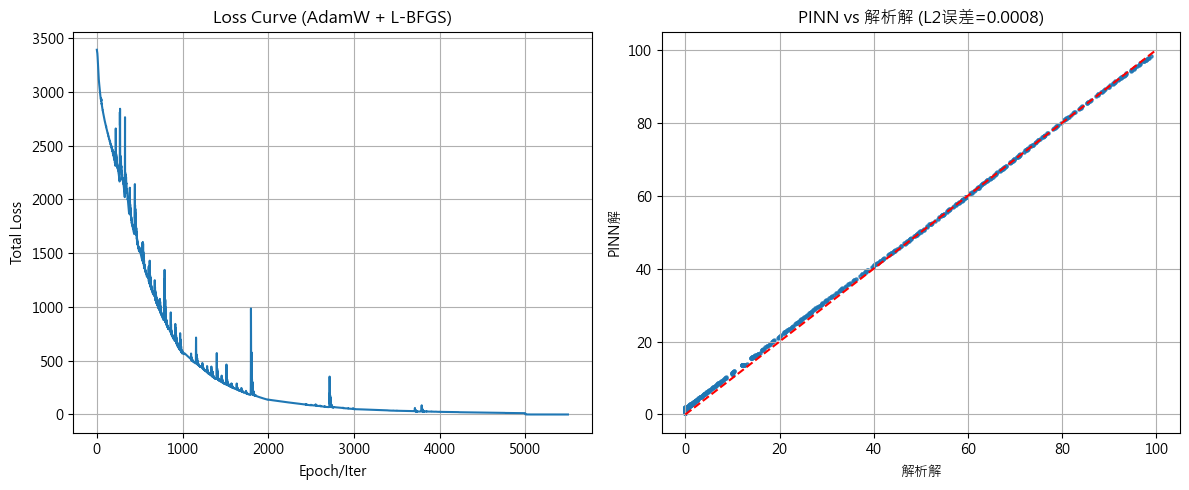


训练完成！AdamW最终λ_f = 328.16


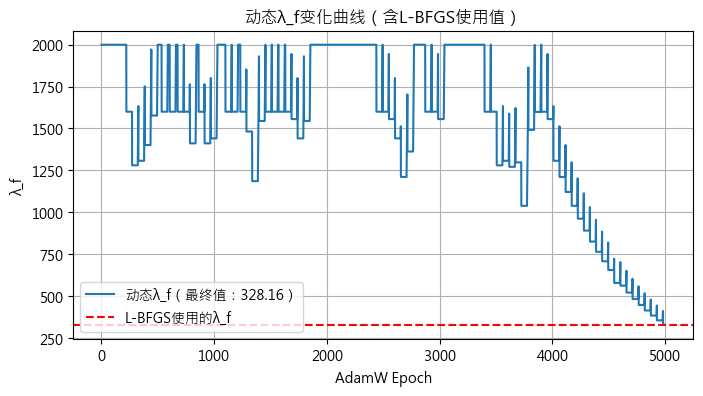

In [14]:
# ====================== 主函数（一键运行） ======================
if __name__ == "__main__":

    # 1. 生成数据（不变）
    (S_u, t_u, V_u), (S_f, t_f), (S_min, S_max, t_min, t_max) = generate_bs_data(N_u=200, N_f=10000)
    S_test, t_test, V_test = generate_bs_test_data(N_test=5000)

    # 2. 初始化模型（不变）
    model = BSPINN(hidden_dim=64, hidden_layers=10)
    model.S_min, model.S_max = S_min, S_max
    model.t_min, model.t_max = t_min, t_max

    # 3. 训练模型（新增接收final_adam_lambda）
    trained_model, loss_history, swa, lambda_f_history, final_adam_lambda = train_pinn(
        model, S_u, t_u, V_u, S_f, t_f,
        epochs_adam=5000,
        epochs_lbfgs=500,
        lr=1e-3
    )

    # 4. 评估与可视化（不变）
    evaluate_and_visualize(trained_model, swa, S_test, t_test, V_test, loss_history)
    

    # 打印最终λ_f并可视化λ_f变化
    print(f"\n训练完成！AdamW最终λ_f = {final_adam_lambda:.2f}")
    plt.figure(figsize=(8, 4))
    plt.plot(lambda_f_history, label=f"动态λ_f（最终值：{final_adam_lambda:.2f}）")
    plt.axhline(y=final_adam_lambda, color='r', linestyle='--', label="L-BFGS使用的λ_f")
    plt.xlabel("AdamW Epoch")
    plt.ylabel("λ_f")
    plt.title("动态λ_f变化曲线（含L-BFGS使用值）")
    plt.legend()
    plt.grid(True)
    plt.show()